In [220]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from os import walk
import matplotlib.pyplot as plt
%matplotlib inline 

In [221]:
#update the mac list - this will only run under Macbook
os.system("scp -i ~/.ssh/router mac-names.txt root@192.168.11.1:/tmp/var/bwmon/www/mac-names.js")

0

In [222]:
# move the dailyfiles - look for a 0 return code
os.system("scp -i ~/.ssh/router root@192.168.11.1:/var/bwmon/data/*.dat /Users/samuelcroker/routerdata")

0

In [223]:
maccsv = '/Users/samuelcroker/Documents/repositories/Router-tools/mac-names.csv'
macdf = pd.read_csv(maccsv, names = ['mac','devicename'],quotechar="'")

In [224]:
dailypath = '/Users/samuelcroker/Documents/routerdata/'
dailyfiles = []
for (dirpath, dirnames, filenames) in walk(dailypath):
    dailyfiles.extend(filenames)
    break

In [225]:
cutoff = 1.5
idx = 0
for f in dailyfiles:
    #print(idx)
    if f[-3:] == 'dat':
        df = pd.read_csv(dailypath+f, names = ['Device','PostIN KB','PostOut KB','PreIn KB','PreOut KB','LastSeen'])
        df['dtstamp'] = np.repeat(dt.date(int(f[6:10]),int(f[10:12]),int(f[12:14])),len(df))
        df['idx'] = idx
        if idx == 0:
            finaldf = df.copy()                 
        else:
            finaldf = pd.concat([finaldf,df])
        idx += 1
finaldf['totalGB'] = (finaldf['PostIN KB'] + finaldf['PostOut KB'])/1e6
#join with devicenames
finaldf = finaldf.merge(macdf, left_on='Device', right_on='mac', how='left')
finaldf.devicename.fillna(finaldf.Device, inplace=True)

In [226]:
Alltotal = finaldf.groupby(['Device','devicename'])['totalGB'].sum()

devicetotal = finaldf.groupby(['devicename'])['totalGB'].sum()
dailytotal = finaldf.groupby(['dtstamp'])['totalGB'].sum()
smalldaily = finaldf[finaldf.totalGB < cutoff].groupby(['dtstamp','devicename'])['totalGB'].sum()

# make the devicenames "other" when the gb is < 1
finaldf.loc[finaldf['totalGB'] < cutoff, 'devicename'] = 'Other'
devicedaily = finaldf.groupby(['dtstamp','devicename'])['totalGB'].sum()

In [227]:
Alltotal

Device             devicename               
00:0d:4b:bf:73:e1   'Roku'                       4.806757
00:1d:c9:d4:6e:39   'FitBit Aria'                0.000012
00:1f:e1:3e:09:8b   'Vonage'                     0.006365
10:1c:0c:21:dd:89   'Chancy iPad'                0.523088
10:ae:60:35:74:d4   'Amelias Kindle'             0.940553
10:ae:60:3d:3d:cd   'Patricks Kindle'            0.864730
24:f0:94:21:03:e1   'Samuels iPhone'             2.495422
24:f0:94:35:1a:f0   'Joyes iPhone'               1.697443
28:f0:76:11:67:98   'iMac'                      10.241555
30:63:6b:2e:65:b6   'Apple Watch'                0.001563
34:02:86:19:91:5a   'SAS Laptop L7A517 Wlan'     0.304379
34:e6:d7:76:40:7d   'SAS Laptop L7A517 Eth'      4.342430
38:63:bb:74:70:d7   'HP - SAS Wlan'              0.000044
38:c9:86:15:50:fa   'iMac ETH'                   0.001431
5c:f5:da:b0:54:ed   'Joyes iPad'                 5.694803
70:56:81:dd:c2:09   'Apple TV'                  77.800207
88:cb:87:8c:75:01   'Sophia

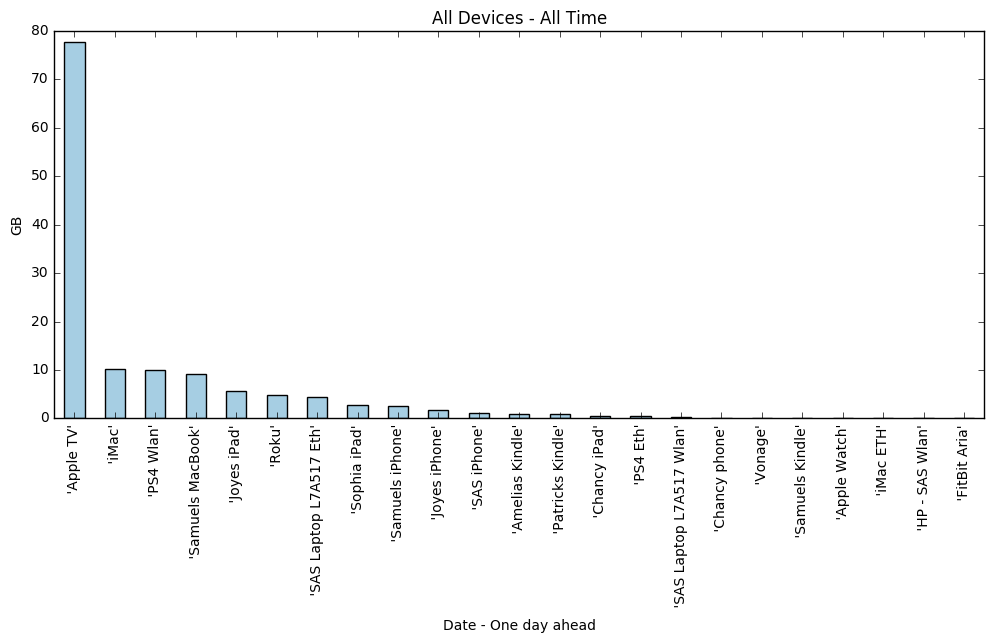

In [228]:
#df0 = devicetotal.unstack('devicename').fillna(0)
pp0 = devicetotal.sort_values(ascending=False).plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5))
pp0.set_xlabel('Date - One day ahead')
pp0.set_ylabel('GB')
pp0.set_title("All Devices - All Time")

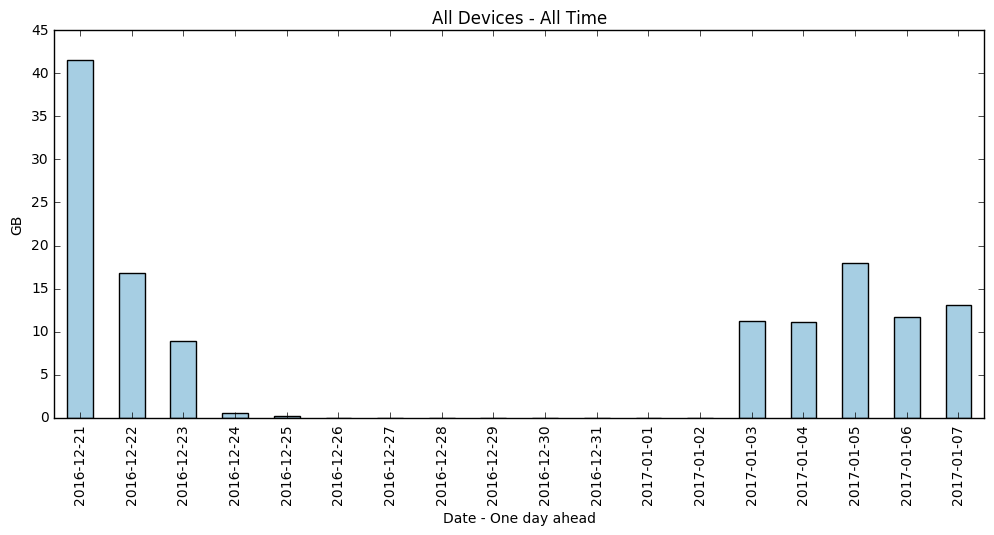

In [229]:
#df0 = devicetotal.unstack('devicename').fillna(0)
pp0 = dailytotal.plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5))
pp0.set_xlabel('Date - One day ahead')
pp0.set_ylabel('GB')
pp0.set_title("All Devices - All Time")

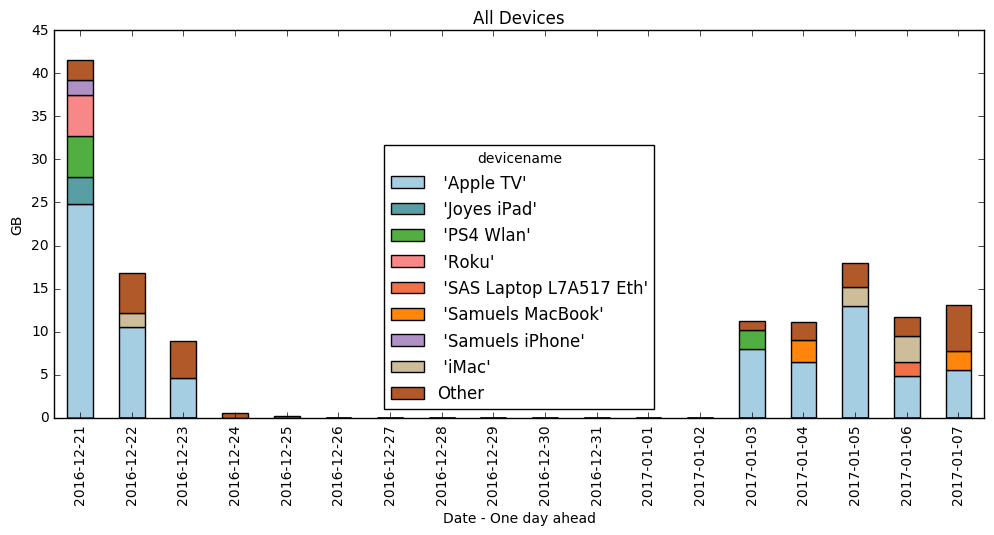

In [230]:
df2 = devicedaily.unstack('devicename').fillna(0)
pp2 = df2.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 5))
pp2.set_xlabel('Date - One day ahead')
pp2.set_ylabel('GB')
pp2.set_title("All Devices")

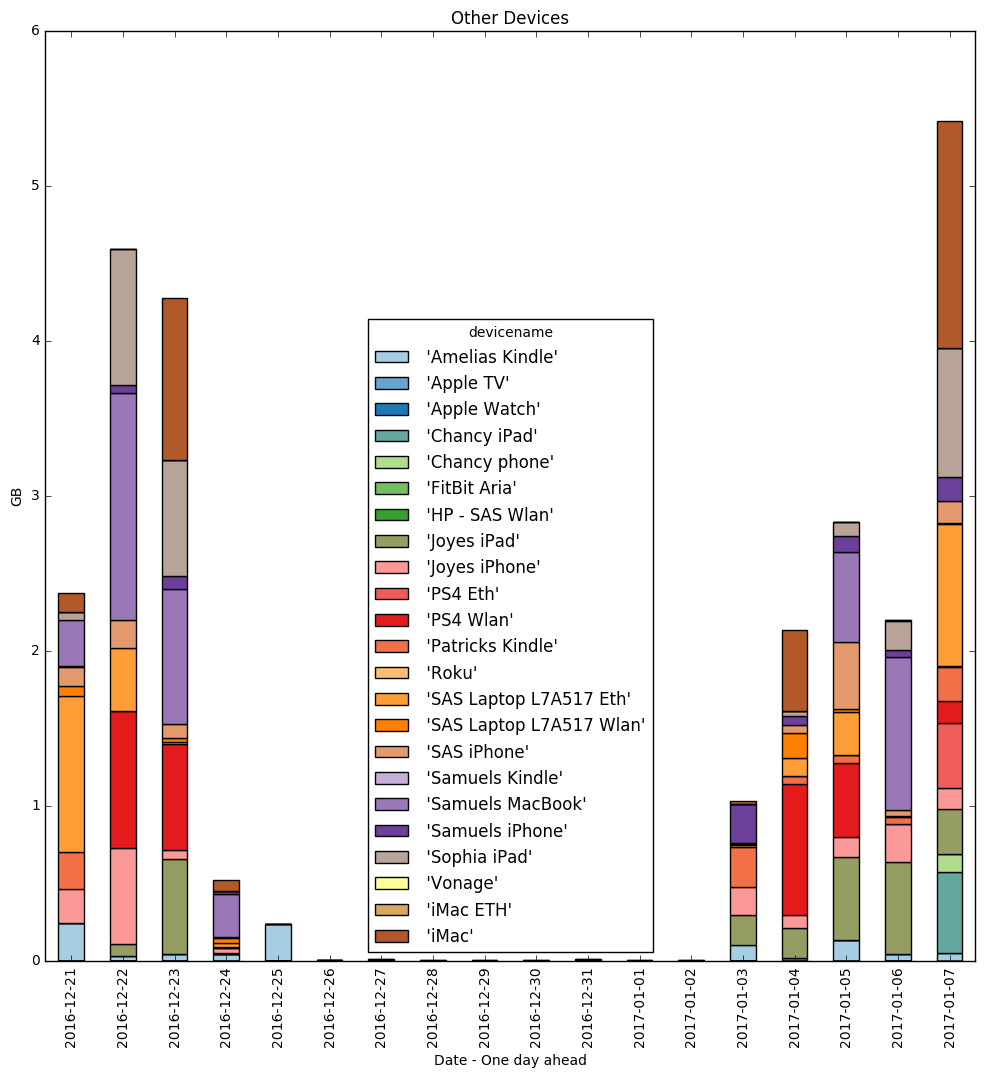

In [231]:
df3 = smalldaily.unstack('devicename').fillna(0)
pp3 = df3.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 12))
pp3.set_xlabel('Date - One day ahead')
pp3.set_ylabel('GB')
pp3.set_title("Other Devices")